# Classification of Kannada MNIST
<!-- ##  ![Preamble of kannada digits](img/kannada_numbers.jpg = 100x200) -->
<div>
<img src="attachment:Screenshot.png" width="500"/>
</div>



In [1]:
# Author: Vikas Chidananda 

# Dataset credits: Vinay Uday Prabhu
# Prabhu, V. (2019, August 03). Kannada-MNIST: A new handwritten DIGITS dataset 
#     for the Kannada language. Retrieved April 19, 2021, 
#     from https://arxiv.org/abs/1908.01242v1

### Numbers in Kannada

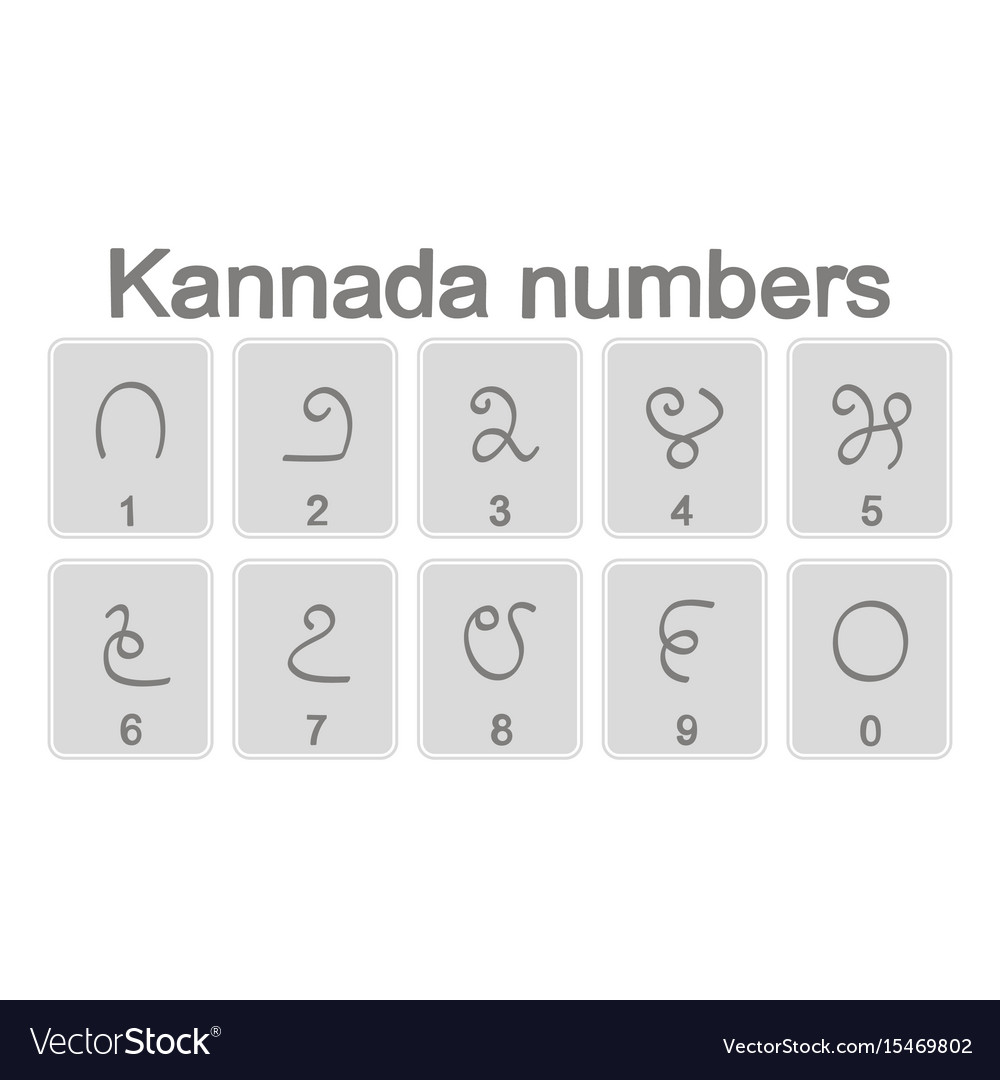

In [2]:
from IPython.display import Image
Image('img/kannada_numbers.jpg', width=400)

In [3]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt 
import matplotlib as mpl

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

font = {'size' : 10}
mpl.rc('font', **font)

In [4]:
import tensorflow as tf
from tqdm import tqdm

In [5]:
path_train_data = 'Kannada-MNIST_data/train.csv'
df_train = pd.read_csv(path_train_data)
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Convert data to numpy arrays and seggregate train and test sets
labels, data = df_train['label'].to_numpy(), df_train.iloc[:, 1:].to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, 
                                                                    test_size = 0.05, 
                                                                    random_state = 1)

In [7]:
# Useful statistics 
num_labels, dim_data = len(np.unique(train_labels)), train_data.shape[-1], 
N_train_data, N_test_data = train_data.shape[0], test_data.shape[0]

# Normalize the data
train_data = train_data/255.0
test_data = test_data/255.0

print(num_labels, dim_data)
print(N_train_data, N_test_data)

10 784
57000 3000


In [8]:
#size of the image = m x m
m = int(np.sqrt(dim_data))
print(m)

28


In [9]:
# store data as images
train_images = train_data.reshape(N_train_data, m, m, 1)
test_images = test_data.reshape(N_test_data, m, m, 1)

In [10]:
#helper function
def print_misclssified(predictions, true_labels):
    idxs = np.where(predictions != true_labels)
    idxs = idxs[0]
    num = len(idxs)
#     print(num)
    n = int(np.sqrt(num)) + 1
#     print(n)
    plt.figure(figsize=(20,20))
    
    for i in range(num):
        plt.subplot(n, n, i+1)

        image_ind = idxs[i]
        digit = test_data[image_ind]
        plt.imshow(np.resize(digit, (28, 28)), cmap = plt.cm.binary)
        plt.xlabel('true:'+str(true_labels[image_ind])+' pred:'+str(predictions[image_ind] ))

## Visualize some of the data

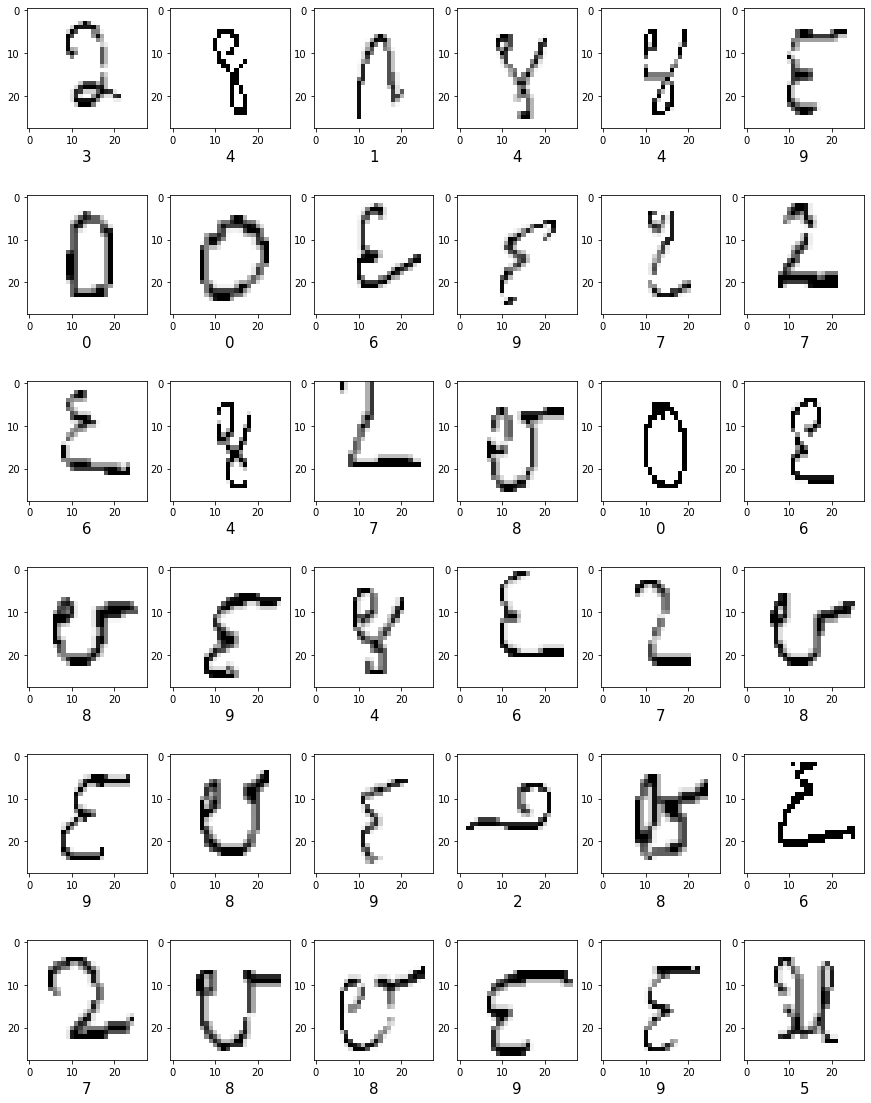

In [11]:
plt.figure(figsize=(15,20))
random_inds = np.random.choice(N_train_data,36)

for i in range(36):
    plt.subplot(6,6,i+1)

    image_ind = random_inds[i]
    digit = train_images[image_ind, :, :, 0]
    plt.imshow(digit, cmap = plt.cm.binary)
    plt.xlabel(train_labels[image_ind], fontsize = 15)

In [85]:
# store socres from each model
score = pd.DataFrame({
    "Classifiers":["LDA", "SVM","Shallow_NN", "Deep_NN", "CNN", "LeNet"],
    "Accuracy":np.zeros(6)
    })
score

,Classifiers,Accuracy
0,LDA,0.0
1,SVM,0.0
2,Shallow_NN,0.0
3,Deep_NN,0.0
4,CNN,0.0
5,LeNet,0.0


### LDA and SVM

In [13]:
clf_lda = LDA()
%timeit clf_lda.fit(train_data, train_labels)

21.4 s ± 5.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
scores = []
print(f'Score on trained data: {clf_lda.score(train_data, train_labels)}')
print(f'Score on test data: {clf_lda.score(test_data, test_labels)}')
scores.append(clf_lda.score(test_data, test_labels))
scores

Score on trained data: 0.9351403508771929
Score on test data: 0.9206666666666666


[0.9206666666666666]

0.9206666666666666

In [15]:
# Since most of the data is empty (0's) let's use LDA to reduce the data space
test_data_reduced = clf_lda.transform(test_data)
train_data_reduced = clf_lda.transform(train_data)
predict_lda = clf_lda.predict(test_data)

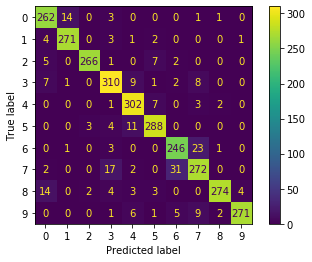

In [16]:
#confusion matrix for LDA classifier
cm = confusion_matrix(test_labels, predict_lda, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

In [87]:
clf_svm = svm.LinearSVC(C = 0.01,
                penalty='l2',
                loss='squared_hinge',
                tol=0.0001,
                multi_class='ovr')

clf_svm.fit(train_data, train_labels) 
      
scores.append(clf_svm.score(test_data, test_labels))
clf_svm.score(test_data, test_labels)
scores

[0.9206666666666666, 0.9553333333333334]

In [18]:
clf_svm_reduced = svm.LinearSVC(C = 0.01,
                penalty='l2',
                loss='squared_hinge',
                tol=0.0001,
                multi_class='ovr')
clf_svm_reduced.fit(train_data_reduced, train_labels)
clf_svm_reduced.score(test_data_reduced, test_labels)

0.9253333333333333

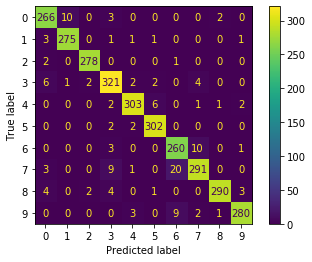

In [19]:
#confusion matrix for linear svc
predict_svm = clf_svm.predict(test_data)
cm = confusion_matrix(test_labels, predict_svm, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

## Deeplearning (NN) with different architectures

In [20]:
def build_model():                                                 #layers as arguments
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return nn_model

model = build_model()

In [21]:
%load_ext tensorboard
import datetime

In [22]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H$M$S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
batch_size = 32
epochs = 5

model.fit(train_data, 
          train_labels, 
          batch_size = batch_size, 
          epochs = epochs,
          callbacks = [tensorboard_callback])

Epoch 1/5
1782/1782 [==============================] - 46s 20ms/step - loss: 0.1864 - accuracy: 0.9468
Epoch 2/5
1782/1782 [==============================] - 36s 20ms/step - loss: 0.0796 - accuracy: 0.9770
Epoch 3/5
1782/1782 [==============================] - 31s 17ms/step - loss: 0.0536 - accuracy: 0.9838
Epoch 4/5
1782/1782 [==============================] - 35s 20ms/step - loss: 0.0399 - accuracy: 0.9886
Epoch 5/5
1782/1782 [==============================] - 30s 17ms/step - loss: 0.0295 - accuracy: 0.9916


In [24]:
%tensorboard --logdir logs/fit

In [25]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('Test accuracy:', test_acc, test_loss)

94/94 - 1s - loss: 0.0577 - accuracy: 0.9793
Test accuracy: 0.9793333411216736 0.057670895010232925


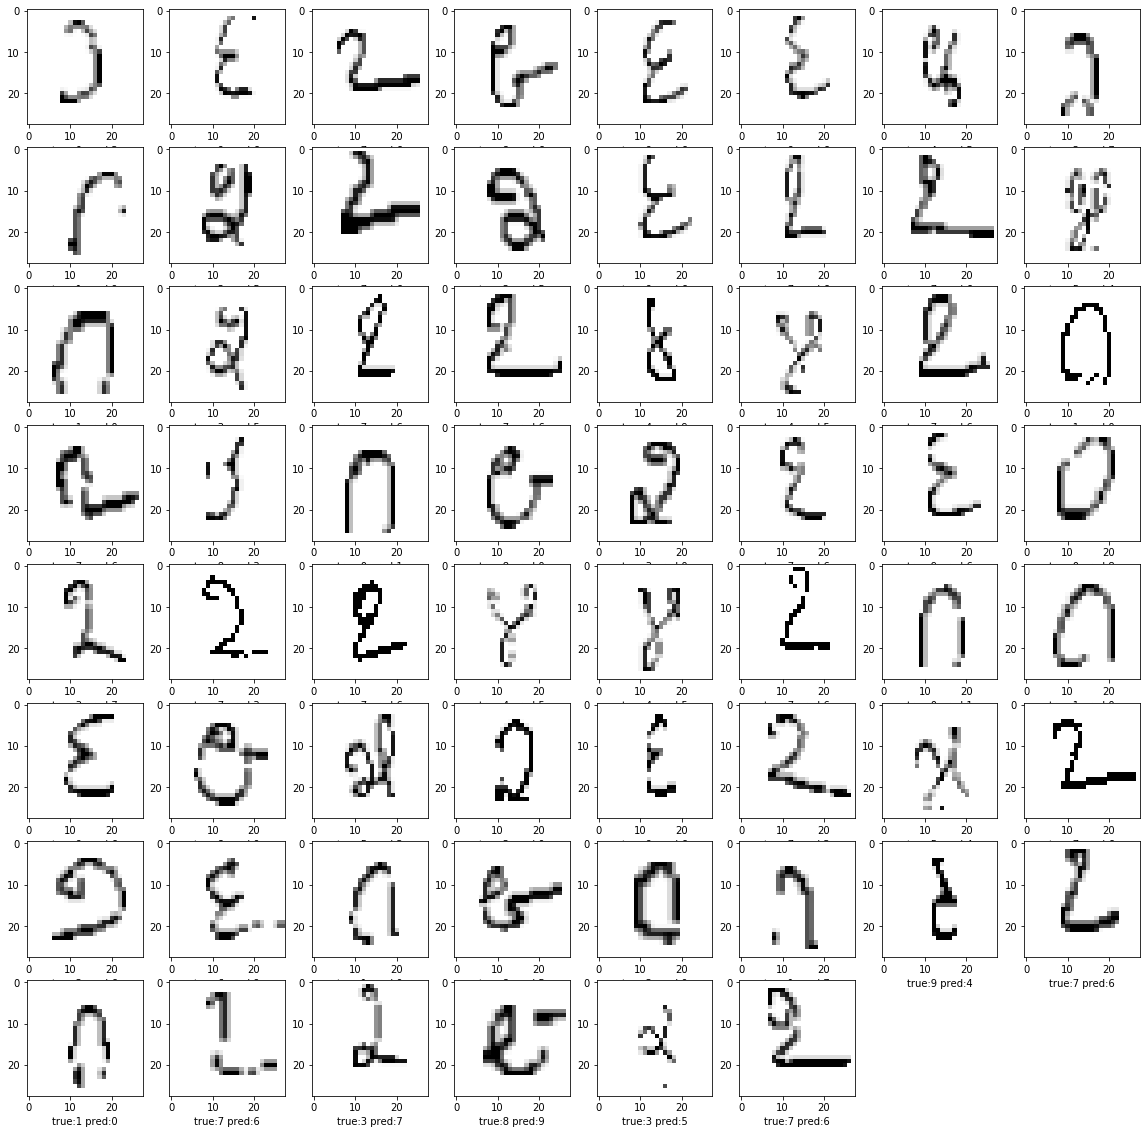

In [26]:
prediction_nn = np.argmax(model.predict(test_data), axis = -1)
print_misclssified(prediction_nn, test_labels)

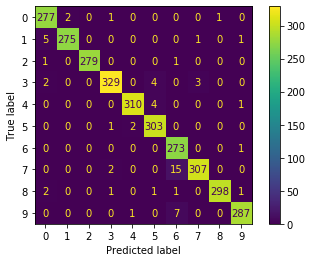

In [27]:
cm = confusion_matrix(test_labels, prediction_nn, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [90]:
784*512 + 784

402192

### With different architectures

In [29]:
def build_model_arch(layers):
    model = tf.keras.Sequential([])
    for i in range(len(layers)):
        model.add(tf.keras.layers.Dense(layers[i], activation = 'relu'))
                  
    model.add(tf.keras.layers.Dense(num_labels, activation = 'sigmoid'))
    return model

#### Deep v/s shallow

In [30]:
deep_layers = np.array([256, 128, 64], dtype = int)
shallow_layers = np.array([128, 128])
deep_nn = build_model_arch(deep_layers)
shallow_nn = build_model_arch(shallow_layers)
models = [deep_nn, shallow_nn]

In [31]:
batch_size = 32
epochs = 5
summary = []
test_scores = []

for model in models:
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
    
    model.fit(train_data, 
          train_labels, 
          batch_size = batch_size, 
          epochs = epochs)
    
    _, test_score = model.evaluate(test_data, test_labels)
    
    test_scores.append(test_score)
    summary.append(model.history)
    

Epoch 1/5
1782/1782 [==============================] - 35s 19ms/step - loss: 0.1818 - accuracy: 0.9454
Epoch 2/5
1782/1782 [==============================] - 28s 16ms/step - loss: 0.0642 - accuracy: 0.9809
Epoch 3/5
1782/1782 [==============================] - 31s 17ms/step - loss: 0.0420 - accuracy: 0.9874
Epoch 4/5
1782/1782 [==============================] - 33s 19ms/step - loss: 0.0277 - accuracy: 0.9917
Epoch 5/5
94/94 [==============================] - 2s 17ms/step - loss: 0.0579 - accuracy: 0.9797
Epoch 1/5
1782/1782 [==============================] - 30s 16ms/step - loss: 0.1858 - accuracy: 0.9462
Epoch 2/5
1782/1782 [==============================] - 32s 18ms/step - loss: 0.0785 - accuracy: 0.9769
Epoch 3/5
1782/1782 [==============================] - 33s 18ms/step - loss: 0.0543 - accuracy: 0.9840
Epoch 4/5
1782/1782 [==============================] - 26s 15ms/step - loss: 0.0397 - accuracy: 0.9881
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.0600

In [32]:
#histograms of wrongly predicted labels
shallow_nn.summary()
test_scores[1]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


0.9783333539962769

In [33]:
deep_nn.summary()
test_scores[0]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


0.9796666502952576

### CNN with different architecture

In [34]:
def CNN_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(24, 3, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(36, 2, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return cnn_model

In [35]:
cnn_model = CNN_model()
cnn_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
                 loss = 'sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [36]:
batch = 64
epochs = 5

cnn_model.fit(train_images, train_labels, 
              batch_size = batch, 
              epochs=epochs)

Epoch 1/5
891/891 [==============================] - 70s 26ms/step - loss: 0.2098 - accuracy: 0.9363
Epoch 2/5
891/891 [==============================] - 19s 21ms/step - loss: 0.0570 - accuracy: 0.9829
Epoch 3/5
891/891 [==============================] - 24s 27ms/step - loss: 0.0376 - accuracy: 0.9882
Epoch 4/5
891/891 [==============================] - 24s 27ms/step - loss: 0.0281 - accuracy: 0.9911
Epoch 5/5
891/891 [==============================] - 23s 26ms/step - loss: 0.0224 - accuracy: 0.9928


In [37]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 36)        3492      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               166016    
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [38]:
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print(f'test accuracy : {test_acc} \t test loss: {test_loss}')

94/94 [==============================] - 2s 18ms/step - loss: 0.0313 - accuracy: 0.9913
test accuracy : 0.9913333058357239 	 test loss: 0.03129655122756958


In [39]:
#what did we misclassify?
predictions = cnn_model.predict(test_images)
predictions = np.argmax(predictions, axis = -1)
idxs = np.where(predictions != test_labels)
misclassified_labels = predictions[idxs]

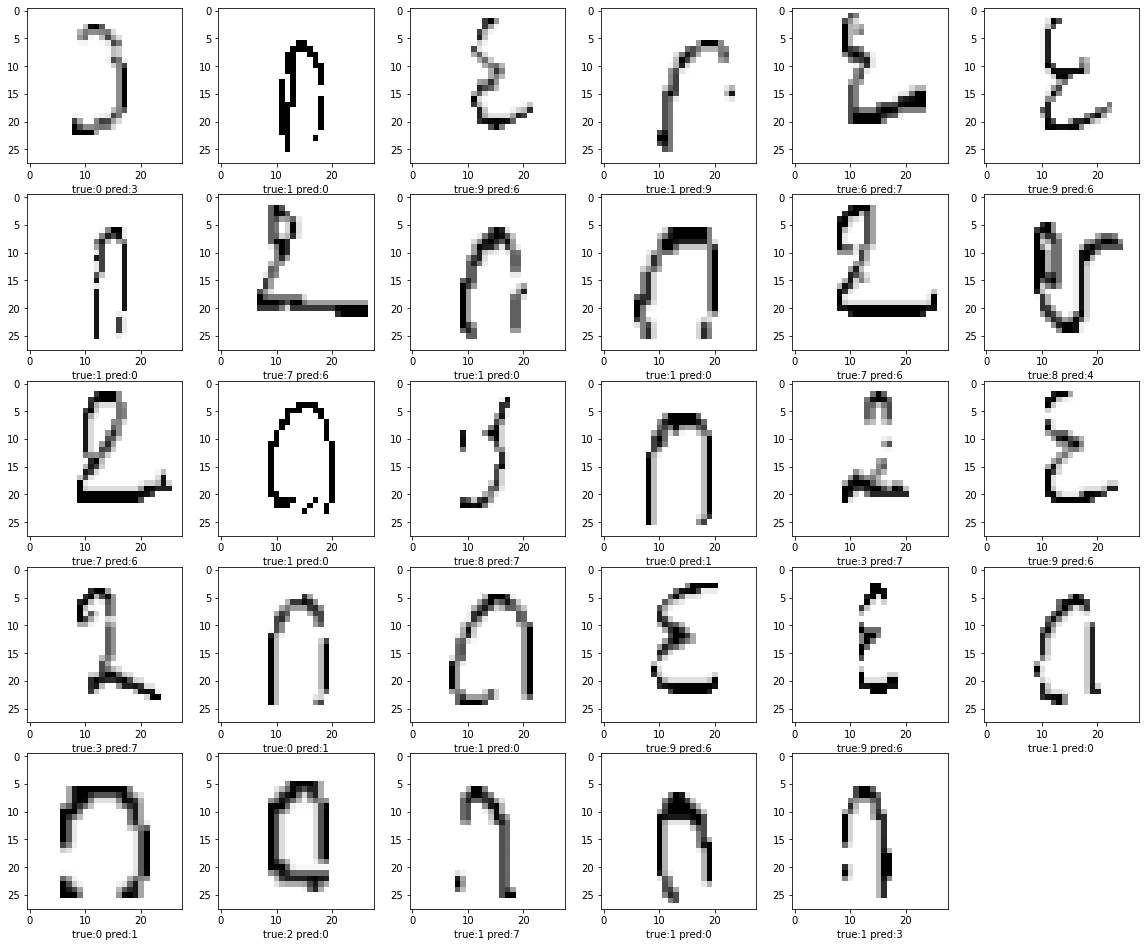

In [40]:
print_misclssified(predictions, test_labels)

### LeNet

In [47]:
def LeNet():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(64, 3, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(84, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return model

In [48]:
LeNet = LeNet()
LeNet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
                 loss = 'sparse_categorical_crossentropy',
                 metrics=['accuracy'])

LeNet.fit(train_images, train_labels, 
              batch_size = batch, 
              epochs=epochs)

Epoch 1/5
891/891 [==============================] - 12s 13ms/step - loss: 0.2382 - accuracy: 0.9249
Epoch 2/5
891/891 [==============================] - 11s 12ms/step - loss: 0.0594 - accuracy: 0.9821
Epoch 3/5
891/891 [==============================] - 11s 12ms/step - loss: 0.0431 - accuracy: 0.9865
Epoch 4/5
891/891 [==============================] - 11s 12ms/step - loss: 0.0351 - accuracy: 0.9892
Epoch 5/5
891/891 [==============================] - 11s 12ms/step - loss: 0.0289 - accuracy: 0.9910


In [49]:
LeNet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)              

In [50]:
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print(f'test accuracy : {test_acc} \t test loss: {test_loss}')

94/94 [==============================] - 1s 6ms/step - loss: 0.0313 - accuracy: 0.9913
test accuracy : 0.9913333058357239 	 test loss: 0.03129655122756958
